In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [2]:
file_path0 = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S2/PRL/241001/IR spectra/Si spectra.xlsx"

In [3]:
# Define the path to your Excel file
file_path = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250328/H2O refractive index.xlsx"
file_path2 = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250604/Au refractive index.xlsx"

# Read the Excel file
df_full0 = pd.read_excel(file_path0, engine='openpyxl', nrows=1868)
df_full = pd.read_excel(file_path, engine='openpyxl', nrows=168)
df_full2 = pd.read_excel(file_path2, engine='openpyxl', nrows=447)

# Extract data columns (indexing starts from 0)
exp_data=df_full0.iloc[:, [0,1,4]]

water_nk = df_full.iloc[:, [1, 2, 3]]
Au_nk = df_full2.iloc[:, [1, 2, 3]]

# Rename the columns for clarity
exp_data.columns = ["Wavenumber (cm⁻¹)", "SiH", "SiOx"]

water_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]
Au_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]

# Filtering
water_nk_filtered = water_nk[(water_nk["Wavenumber (cm⁻¹)"] >= 400) & (water_nk["Wavenumber (cm⁻¹)"] <= 6000)].reset_index(drop=True)
Au_nk_filtered = Au_nk[(Au_nk["Wavenumber (cm⁻¹)"] >= 400) & (Au_nk["Wavenumber (cm⁻¹)"] <= 6000)].reset_index(drop=True)

In [4]:
exp_data

,Wavenumber (cm⁻¹),SiH,SiOx
0,401.191934,1.504827,0.098880
1,403.120741,1.501793,0.098812
2,405.049548,1.488644,0.099045
3,406.978356,1.464133,0.099306
4,408.907163,1.475930,0.099051
...,...,...,...
1862,3992.631262,0.452293,0.243349
1863,3994.560070,0.452649,0.243391
1864,3996.488877,0.451951,0.243482
1865,3998.417684,0.452050,0.243376


In [5]:
exp_wavenumbers = exp_data["Wavenumber (cm⁻¹)"].values
Abs_SiH = exp_data["SiH"].values
Abs_SiOx = exp_data["SiOx"].values

In [6]:
# Extract x and y from gold data
Au_wavenumbers = Au_nk_filtered["Wavenumber (cm⁻¹)"].values
Au_n = Au_nk_filtered["n (real)"].values
Au_k = Au_nk_filtered["k (imag)"].values

# Reference wavenumbers from water
target_wavenumbers = water_nk_filtered["Wavenumber (cm⁻¹)"].values

# Create interpolation functions with extrapolation enabled
interp_n_func = interp1d(Au_wavenumbers, Au_n, kind='linear', fill_value="extrapolate")
interp_k_func = interp1d(Au_wavenumbers, Au_k, kind='linear', fill_value="extrapolate")

# Evaluate interpolated (or extrapolated) values at water wavenumbers
interp_n = interp_n_func(target_wavenumbers)
interp_k = interp_k_func(target_wavenumbers)

# Create new DataFrame with interpolated gold data
Au_interp = pd.DataFrame({
    "Wavenumber (cm⁻¹)": target_wavenumbers,
    "n (real)": interp_n,
    "k (imag)": interp_k
})

# Merge water and gold refractive index data on wavenumber
merged_nk = pd.merge(
    water_nk_filtered,
    Au_interp,
    on="Wavenumber (cm⁻¹)",
    suffixes=("_water", "_Au")
)

In [7]:
wavenumbers_short = merged_nk['Wavenumber (cm⁻¹)'].values

——————————————————————————————————Obtained dataframe of refractive indices————————————————————————————————————————————

In [8]:

def three_layer_transmission_amplitude(n0, n1, n2, d1, wavelength, theta0_deg, pol='s'):
    n0 = complex(n0)
    n1 = complex(n1)
    n2 = complex(n2)

    theta0_rad = np.radians(theta0_deg)

    # Snell's Law
    sin_theta1 = (n0 / n1) * np.sin(theta0_rad)
    theta1 = np.arcsin(sin_theta1)

    sin_theta2 = (n0 / n2) * np.sin(theta0_rad)
    theta2 = np.arcsin(sin_theta2)

    # Fresnel coefficients
    def fresnel_r(n_i, n_j, theta_i, theta_j, pol):
        if pol == 's':
            return (n_i * np.cos(theta_i) - n_j * np.cos(theta_j)) / (n_i * np.cos(theta_i) + n_j * np.cos(theta_j))
        elif pol == 'p':
            return (n_j * np.cos(theta_i) - n_i * np.cos(theta_j)) / (n_j * np.cos(theta_i) + n_i * np.cos(theta_j))
        else:
            raise ValueError("Polarization must be 's' or 'p'")

    def fresnel_t(n_i, n_j, theta_i, theta_j, pol):
        if pol == 's':
            return (2 * n_i * np.cos(theta_i)) / (n_i * np.cos(theta_i) + n_j * np.cos(theta_j))
        elif pol == 'p':
            return (2 * n_i * np.cos(theta_i)) / (n_j * np.cos(theta_i) + n_i * np.cos(theta_j))
        else:
            raise ValueError("Polarization must be 's' or 'p'")

    r01 = fresnel_r(n0, n1, theta0_rad, theta1, pol)
    r12 = fresnel_r(n1, n2, theta1, theta2, pol)
    t01 = fresnel_t(n0, n1, theta0_rad, theta1, pol)
    t12 = fresnel_t(n1, n2, theta1, theta2, pol)

    # Phase thickness
    delta = (2 * np.pi / wavelength) * n1 * d1 * np.cos(theta1)

    # Transmission amplitude
    t_total = (t01 * t12 * np.exp(1j * delta)) / (1 + r01 * r12 * np.exp(2j * delta))

    return t_total


In [9]:
# n0 = 3.5       # Si
# n1 = 0.2 + 3j  # Au
# n2 = 1.33      # Water
# d1 = 10e-9     # 10 nm
# wl = 2e-6      # 2 µm
# theta = 30     # degrees

# t_amp_s = three_layer_transmission_amplitude(n0, n1, n2, d1, wl, theta, pol='s')
# t_amp_p = three_layer_transmission_amplitude(n0, n1, n2, d1, wl, theta, pol='p')


In [10]:
# print(three_layer_reflectance(3.417, 1.242+0.003170j, 1,  10e-9 ,  4e-6 , 18, pol='s'))
# print(three_layer_reflectance(3.417, 1.242+0.003170j, 0.885036	+16.869057j,  10e-9 ,  4e-6 , 18, pol='s'))

In [11]:
# merged_nk

In [12]:
# Constants
n_Si = 3.417 + 0j  # Refractive index of Si
d_gold = 8e-9     # 10 nm film
n_air = 1.0 + 0j

# Arrays
wavenumbers = merged_nk["Wavenumber (cm⁻¹)"].values
wavelengths = 1e-2 / wavenumbers  # Convert cm⁻¹ to meters
n_Au = merged_nk["n (real)_Au"].values + 1j * merged_nk["k (imag)_Au"].values
n_water = merged_nk["n (real)_water"].values + 1j * merged_nk["k (imag)_water"].values

In [13]:
def compute_transmittance_air_with_ratio(theta_deg):
    t_au_s = []
    t_au_p = []
    T_au = []
    Ts_au = []
    Tp_au = []

    T_no_au = []  # Total (unpolarized) transmittance without Au layer
    Ts_no_au = []
    Tp_no_au = []

    ratio_T = []     # Averaged ratio
    ratio_Ts = []    # s-polarized
    ratio_Tp = []    # p-polarized

    theta0_rad = np.radians(theta_deg)
    cos_theta0 = np.cos(theta0_rad)

    for wl, n1 in zip(wavelengths, n_Au):
        # --- Snell's law for Si → air ---
        sin_theta2 = (n_Si / n_air) * np.sin(theta0_rad)
        theta2 = np.arcsin(sin_theta2)
        cos_theta2 = np.cos(theta2)

        # --- With gold layer: Si–Au–air ---
        t_s_au = three_layer_transmission_amplitude(n_Si, n1, n_air, d_gold, wl, theta_deg, pol='s')
        t_p_au = three_layer_transmission_amplitude(n_Si, n1, n_air, d_gold, wl, theta_deg, pol='p')

        T_s_au = abs(t_s_au)**2 * (n_air.real * cos_theta2.real) / (n_Si.real * cos_theta0.real)
        T_p_au = abs(t_p_au)**2 * (n_air.real * cos_theta2.real) / (n_Si.real * cos_theta0.real)

        t_au_s.append(t_s_au)
        t_au_p.append(t_p_au)
        Ts_au.append(T_s_au)
        Tp_au.append(T_p_au)
        T_au.append((T_s_au + T_p_au) / 2)

        # --- Without gold layer: Si–air  ---
        t_s_no_au = three_layer_transmission_amplitude(n_Si, n_air, n_air, 0, wl, theta_deg, pol='s')
        t_p_no_au = three_layer_transmission_amplitude(n_Si, n_air, n_air, 0, wl, theta_deg, pol='p')

        T_s_no_au = abs(t_s_no_au)**2 * (n_air.real * cos_theta2.real) / (n_Si.real * cos_theta0.real)
        T_p_no_au = abs(t_p_no_au)**2 * (n_air.real * cos_theta2.real) / (n_Si.real * cos_theta0.real)

        Ts_no_au.append(T_s_no_au)
        Tp_no_au.append(T_p_no_au)
        T_no_au.append((T_s_no_au + T_p_no_au) / 2)

        # --- Transmittance ratios ---
        ratio_T.append((T_s_au + T_p_au) / (T_s_no_au + T_p_no_au))
        ratio_Ts.append(T_s_au / T_s_no_au)
        ratio_Tp.append(T_p_au / T_p_no_au)

    return {
        "wavenumbers": wavenumbers,
        "wavelengths": wavelengths,
        "T_au": T_au,
        "Ts_au": Ts_au,
        "Tp_au": Tp_au,
        "T_no_au": T_no_au,
        "Ts_no_au": Ts_no_au,
        "Tp_no_au": Tp_no_au,
        "ratio_T": ratio_T,
        "ratio_Ts": ratio_Ts,
        "ratio_Tp": ratio_Tp
    }


In [14]:
# Prepare output dictionary
angle_dict_T = {}
angles_deg = [0, 90]  # or any list of angles you want

# Loop over angles
for angle in angles_deg:
    results = compute_transmittance_air_with_ratio(angle)

    df = pd.DataFrame({
        "wavenumber": results["wavenumbers"],
        "T_au": results["T_au"],          # Si–Au–air
        "T_air": results["T_no_au"],      # Si–air
        "T_ratio": results["ratio_T"]     # T_au / T_air
    })

    angle_dict_T[angle] = df


In [15]:
angle_dict_T

{0:       wavenumber      T_au     T_air   T_ratio
 0    5555.555556  0.347763  0.700568  0.496401
 1    5000.000000  0.321420  0.700568  0.458800
 2    4545.454545  0.289374  0.700568  0.413056
 3    4166.666667  0.261444  0.700568  0.373188
 4    3846.153846  0.236807  0.700568  0.338022
 ..           ...       ...       ...       ...
 98    476.190476  0.012716  0.700568  0.018151
 99    454.545455  0.012093  0.700568  0.017261
 100   434.782609  0.011541  0.700568  0.016474
 101   416.666667  0.011012  0.700568  0.015719
 102   400.000000  0.010556  0.700568  0.015068
 
 [103 rows x 4 columns],
 90:       wavenumber          T_au         T_air    T_ratio
 0    5555.555556  1.106727e-31  8.903609e-33  12.430090
 1    5000.000000  6.317860e-32  8.903609e-33   7.095842
 2    4545.454545  3.466767e-32  8.903609e-33   3.893665
 3    4166.666667  2.207544e-32  8.903609e-33   2.479381
 4    3846.153846  1.536213e-32  8.903609e-33   1.725382
 ..           ...           ...           ...   

——————————————————————————————————Obtained dictionary of angles vs. Transimittance————————————————————————————————————————————

——————————————————————————————————————T vs. wavenumber——————————————————————————————————————

exp_wavenumbers = exp_data["Wavenumber (cm⁻¹)"].values
Abs_SiH = exp_data["SiH"].values
Abs_SiOx = exp_data["SiOx"].values

In [16]:
Abs_SiOx_interp = np.interp(wavenumbers_short, exp_wavenumbers, Abs_SiOx)
Abs_SiH_interp = np.interp(wavenumbers_short, exp_wavenumbers, Abs_SiH)

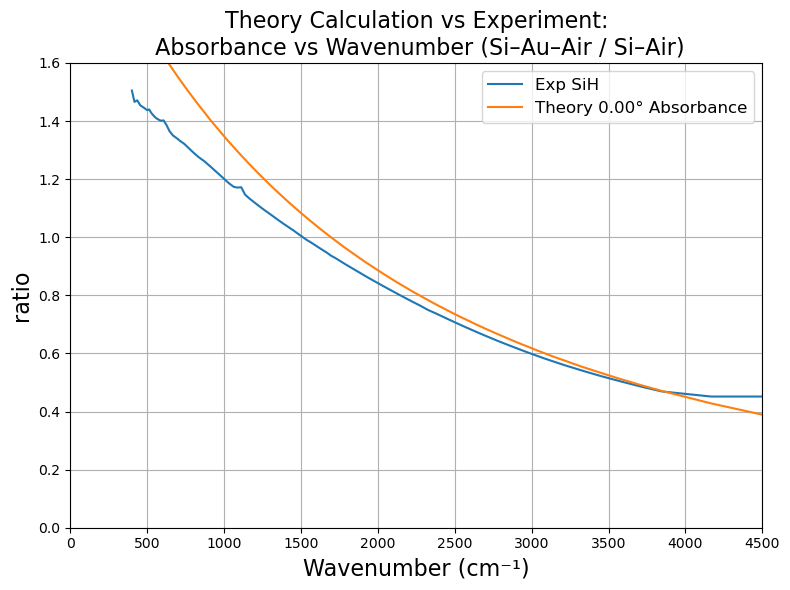

In [22]:
# Select target angles (in degrees)
target_angles = [0] 

# Get available angles from angle_dict_T
available_angles_T = np.array(sorted(angle_dict_T.keys()))

# Match target angles to the closest available in angle_dict_T
matched_angles_T = [available_angles_T[np.argmin(np.abs(available_angles_T - a))] for a in target_angles]

# Plot
plt.figure(figsize=(10, 6))
# Customize plot
plt.plot(wavenumbers_short, Abs_SiH_interp, label=f"Exp SiH")
# plt.plot(wavenumbers_short, Abs_SiOx_interp, label=f"Exp SiOx")
for angle in matched_angles_T:
    df = angle_dict_T[angle]
    wn = df["wavenumber"].values
    T_ratio = df["T_ratio"].values
    Absorbance = -np.log10(T_ratio)

    #plt.plot(wn, T_ratio, label=f"{angle:.2f}° Transimittance")
    plt.plot(wn, Absorbance, label=f"Theory {angle:.2f}° Absorbance")



# plt.plot(exp_wavenumbers, Abs_SiH, label=f"Exp SiH Absorbance")
# plt.plot(exp_wavenumbers, Abs_SiOx, label=f"Exp SiOx Absorbance")
# plt.plot(wavenumbers_short, Abs_SiH_interp/Absorbance, label=f"Abs_SiH_interp/Absorbance")


plt.title(f"Theory Calculation vs Experiment:\n Absorbance vs Wavenumber (Si–Au–Air / Si–Air)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("ratio", fontsize=16)
plt.xlim(0, 4500)
plt.ylim(0, 1.6)
plt.grid(True)

# Place legend outside
plt.legend(fontsize = 12)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin for legend

plt.show()


——————————————————————————————————————Contour maps——————————————————————————————————————

In [18]:
# # Sort angles and extract wavenumbers
# angles = sorted(angle_dict_T.keys())
# wavenumbers = np.array(angle_dict_T[angles[0]]['wavenumber'].values)

# # Clip wavenumber range
# wmin, wmax = 950, 6000
# mask = (wavenumbers >= wmin) & (wavenumbers <= wmax)
# wavenumbers_clipped = wavenumbers[mask]

# # Create 2D matrix for T_avg
# T_matrix = np.array([angle_dict_T[angle]['T_avg'].values[mask] for angle in angles])

# # Meshgrid
# W_grid, A_grid = np.meshgrid(wavenumbers_clipped, angles)

# # Plot
# levels = np.linspace(0, 0.7, 256)
# plt.figure(figsize=(8, 6))  
# contour = plt.contourf(W_grid, A_grid, T_matrix, levels=levels, cmap='jet', extend='neither')
# cbar = plt.colorbar(contour)
# cbar.set_label('Average Transmittance T = (Ts + Tp)/2')
# cbar.set_ticks([0,0.1, 0.2,0.3, 0.4])

# plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
# plt.ylabel("Angle of Incidence (degrees)", fontsize=16)
# plt.title(f"Theory Calculation ({d_gold*1e9:.0f}nm Au): T_avg (Si–Au–Air)", fontsize=16)
# plt.tight_layout()
# plt.show()


In [19]:
# # Create 2D matrices for Ts and Tp
# Ts_matrix = np.array([angle_dict_T[angle]['Ts_air'].values[mask] for angle in angles])
# Tp_matrix = np.array([angle_dict_T[angle]['Tp_air'].values[mask] for angle in angles])

# # Define contour levels
# levels = np.linspace(0, 0.7, 256)
# tick_vals = [0, 0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7]

# # Create side-by-side subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# # --- Plot Ts ---
# cs1 = ax1.contourf(W_grid, A_grid, Ts_matrix, levels=levels, cmap='jet', extend='neither')
# cbar1 = fig.colorbar(cs1, ax=ax1)
# cbar1.set_label('s-Polarized Transmittance (Ts)')
# cbar1.set_ticks(tick_vals)
# ax1.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
# ax1.set_ylabel("Angle of Incidence (degrees)", fontsize=14)
# ax1.set_title(f"Ts (Si–Au–Air, {d_gold*1e9:.0f} nm Au)", fontsize=15)
# ax1.grid(False)

# # --- Plot Tp ---
# cs2 = ax2.contourf(W_grid, A_grid, Tp_matrix, levels=levels, cmap='jet', extend='neither')
# cbar2 = fig.colorbar(cs2, ax=ax2)
# cbar2.set_label('p-Polarized Transmittance (Tp)')
# cbar2.set_ticks(tick_vals)
# ax2.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
# ax2.set_ylabel("Angle of Incidence (degrees)", fontsize=14)
# ax2.set_title(f"Tp (Si–Au–Air, {d_gold*1e9:.0f} nm Au)", fontsize=15)
# ax2.grid(False)

# plt.tight_layout()
# plt.show()


——————————————————————————————————————T vs. angle——————————————————————————————————————

In [20]:
# # Choose target wavenumbers (approximate)
# target_wavenumbers = [1500, 2000, 3200, 4000, 5000]

# # Extract sorted angle list
# angles = sorted(angle_dict_T.keys())

# # Prepare figure
# plt.figure(figsize=(8, 6))

# for wn_target in target_wavenumbers:
#     T_values = []

#     for angle in angles:
#         T_data = angle_dict_T[angle]
#         # Find index of closest wavenumber
#         idx_closest = (T_data["wavenumber"] - wn_target).abs().idxmin()
#         T_avg = T_data.loc[idx_closest, "T_avg"]
#         T_values.append(T_avg)

#     matched_wn = round(T_data.loc[idx_closest, "wavenumber"], 2)
#     plt.plot(angles, T_values, '-', label=f'{matched_wn} cm⁻¹')

# # Customize plot
# plt.title(f"Theory Calculation ({d_gold*1e9:.0f}nm Au): T_avg vs Angle (Si–Au–Air)", fontsize=16)
# plt.xlabel("Angle of Incidence (degrees)", fontsize=16)
# plt.ylabel("Average Transmittance", fontsize=16)
# plt.ylim(0, 1.2)
# plt.grid(True)
# plt.legend(title="Wavenumber", fontsize=14)
# plt.tight_layout()
# plt.show()


In [21]:
# # Choose target wavenumbers (approximate)
# target_wavenumbers = [1500, 2000, 3200, 4000, 5000]

# # Extract sorted angle list
# angles = sorted(angle_dict_T.keys())

# # Create subplots for Ts and Tp
# fig, (ax_s, ax_p) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# for wn_target in target_wavenumbers:
#     Ts_values = []
#     Tp_values = []

#     for angle in angles:
#         T_data = angle_dict_T[angle]
#         # Find index of closest wavenumber
#         idx_closest = (T_data["wavenumber"] - wn_target).abs().idxmin()
#         Ts = T_data.loc[idx_closest, "Ts_air"]
#         Tp = T_data.loc[idx_closest, "Tp_air"]
#         Ts_values.append(Ts)
#         Tp_values.append(Tp)

#     matched_wn = round(T_data.loc[idx_closest, "wavenumber"], 2)
#     ax_s.plot(angles, Ts_values, '-', label=f'{matched_wn} cm⁻¹')
#     ax_p.plot(angles, Tp_values, '-', label=f'{matched_wn} cm⁻¹')

# # Customize Ts subplot
# ax_s.set_title(f"{d_gold*1e9:.0f}nm Au: $T_s$ vs Angle", fontsize=16)
# ax_s.set_xlabel("Angle of Incidence (degrees)", fontsize=14)
# ax_s.set_ylabel("Transmittance (s-pol)", fontsize=14)
# ax_s.set_ylim(0, 1.2)
# ax_s.grid(True)
# ax_s.legend(title="Wavenumber", fontsize=12)

# # Customize Tp subplot
# ax_p.set_title(f"{d_gold*1e9:.0f}nm Au: $T_p$ vs Angle", fontsize=16)
# ax_p.set_xlabel("Angle of Incidence (degrees)", fontsize=14)
# ax_p.set_ylabel("Transmittance (p-pol)", fontsize=14)
# ax_p.set_ylim(0, 1.2)
# ax_p.grid(True)
# ax_p.legend(title="Wavenumber", fontsize=12)

# plt.tight_layout()
# plt.show()
